In [ ]:
!pip install lime gensim keras transformers

In [ ]:
## for data
import json
import pandas as pd
import numpy as np
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for processing
import re
# import nltk
## for bag-of-words
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing
## for explainer
from lime import lime_text
## for word embedding
import gensim
import gensim.downloader as gensim_api
## for deep learning
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K
## for bert language model
import transformers

# Pre-processing

In [ ]:
train_raw = pd.read_csv("YOUR_TRAIN_PATH", sep='#')
test_raw = pd.read_csv("YOUR_TEST_PATH", sep='#')

In [ ]:
def preprocess(df):
  removed_cols = ['Unnamed: 0',
                  'Unnamed: 0.1',
 'CVE Page',
 'Summary',
 'Vulnerability Classification',
 'codeLink',
 'commit_id',
 'commit_message',
 'del_lines',
 'file_name',
 'func_before',
 'vul_func_with_fix',
 'flaw_line',
 'flaw_line_index',
 'vul_func_with_fix',
 'processed_func',
 'sql',
 'r.spl.',
 'dir.',
 'trav.',
 'http',
 'xss',
 'corr.',
 'cpg']
  
  try:
      df = df.rename({'processed_func' : 'text', '+info': 'info', '+priv': 'priv', 'mem.' : 'mem'}, axis=1, inplace=False)
  except:
      print("RENAMED")

  for c in removed_cols:
    try:
      df = df.drop(c, axis=1)
    except:
      print(c)
  df = df.drop('code', axis=1)
  return df

In [ ]:
train_df = preprocess(train_raw)
test_df = preprocess(test_raw)

In [ ]:
def hamming_score(preds, lbs):
    sum_ratio = 0.0
    for i, row in preds.iterrows():
        upper = 0
        lower = 0
        ratio = 0.0
        for lb in LABEL_COLUMNS:
            logic_and = preds[lb][i] + lbs[lb][i]
            if logic_and == 2:
                upper = upper+1
                lower = lower+1
            if logic_and == 1:
                lower = lower+1
        if lower != 0:
            ratio = upper/lower
        sum_ratio = sum_ratio+ratio
    return sum_ratio/len(preds)

def exact_match_ratio(preds, lbs):
    sum_ratio = 0.0
    for i, row in preds.iterrows():
        upper = 0
        ratio = 0.0
        for lb in LABEL_COLUMNS:
            if preds[lb][i] == lbs[lb][i]:
                upper = upper+1
            ratio = upper/len(LABEL_COLUMNS)
        sum_ratio = sum_ratio+ratio
    return sum_ratio/len(preds)

def get_labels(labels, record):
  result = []
  for i in range(len(record)):
    if record[i] == 1:
      result.append(labels[i])
  return result

In [ ]:
from sklearn.metrics import classification_report, multilabel_confusion_matrix
LABEL_COLUMNS = train_df.columns.tolist()[2:]

# BOW - TF-IDF

In [ ]:
def code_tokenizer(identifier):
    #camelcase
    identifier = re.sub("[^a-zA-Z]+", "", identifier)
    subtokens = set()
    parts = filter(None, re.split("[, \-!?:_~]+", identifier))
#     identifier.split('_')
    for part in parts:
        if not part.isdigit():
            splitted = re.sub('([A-Z][a-z]+)', r' \1', re.sub('([A-Z]+)', r' \1', part)).split()
            lower_tokens = [item.lower() for item in splitted]
            subtokens.update(set(lower_tokens))
    return subtokens

def comment_remover(text):
    def replacer(match):
        s = match.group(0)
        if s.startswith('/'):
            return " "
        else:
            return s
    pattern = re.compile(
        r'//.*?$|/\*.*?\*/|\'(?:\\.|[^\\\'])*\'|"(?:\\.|[^\\"])*"',
        re.DOTALL | re.MULTILINE
    )
    return re.sub(pattern, replacer, text)

def string_lit_remover(text):
    return re.sub(r'".*"', 'strlitplaceholder', text)

In [ ]:
def code_tokenizer(identifier):
    identifier = re.sub("[^a-zA-Z]+", "", identifier)
    result = ""
    parts = filter(None, re.split("[, \-!?:_~]+", identifier))
    for part in parts:
        if not part.isdigit():
            splitted = re.sub('([A-Z][a-z]+)', r' \1', re.sub('([A-Z]+)', r' \1', part)).split()
            lower_tokens = [item.lower() for item in splitted]
            for token in lower_tokens:
              result = result+ " " + token
    return result.strip()

def merge_code(code):
    output = ""
    for unit in code:
        output = output + " "+code_tokenizer(unit)
    return output.strip()

def preprocess_code(code_):
  code_ = code_.splitlines()
  result = ""
  for line in code_:
    line = re.sub('[^a-zA-Z0-9]', ' ', line)
    line = re.sub(' +', ' ', line)
    # line = re.sub(r"([A-Z])", r" \1", line).split()
    line = line.split(" ")
    line = merge_code(line)
    result = result+" "+line
  return result.strip()

# print(preprocess_code(train_df['text'][5]))

In [ ]:
def preprocess_raw(df):
    tag_col = []
    for ind in df.index:
        code = df['text'][ind]
        code = comment_remover(code)
        code = string_lit_remover(code)
        df['text'][ind] = preprocess_code(code)
        lbs = []
        for lb in LABEL_COLUMNS:
          if df[lb][ind] == 1:
            lbs.append(lb)
        tag_col.append(lbs)
    df['tags']  = tag_col

preprocess_raw(train_df)
preprocess_raw(test_df)

In [ ]:
train_text = train_df['text']
test_text = test_df['text']

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = feature_extraction.text.TfidfVectorizer(max_features=20000, ngram_range=(1,2))
vectorizer.fit(train_text)
vectorizer.fit(test_text)

TfidfVectorizer(max_features=20000, ngram_range=(1, 2))

In [ ]:
x_train = vectorizer.transform(train_text)
y_train = train_df.drop(labels = ['index','text', 'tags'], axis=1)
x_test = vectorizer.transform(test_text)
y_test = test_df.drop(labels = ['index','text', 'tags', 'Unnamed: 0.1.1'], axis=1)

In [ ]:
y_test

In [ ]:
y_test = y_test[y_train.columns.tolist()]

In [ ]:
!pip install scikit-multilearn

## BinaryRelevance

In [ ]:
# using binary relevance
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
# initialize binary relevance multi-label classifier
# with a gaussian naive bayes base classifier
classifier_bin = BinaryRelevance(GaussianNB())
# train
classifier_bin.fit(x_train, y_train)
# predict
# accuracy


In [ ]:
# for row in predictions_bin:
#   print("xx: "+str(row.shape))
predictions_bin = classifier_bin.predict(x_test)
prediction_bin = pd.DataFrame(predictions_bin.toarray(), columns=LABEL_COLUMNS)
print("Subset accuracy = ",accuracy_score(y_test, predictions_bin))

Subset accuracy =  0.5383886255924171


In [ ]:
y_pred = prediction_bin.to_numpy()
y_true = y_test.to_numpy()
print(classification_report(
  y_true, 
  y_pred, 
  target_names=LABEL_COLUMNS, 
  zero_division=0
))

In [ ]:
print("Hamming score: " + str(hamming_score(prediction_bin, y_test)))
print("Exact match ratio: " + str(exact_match_ratio(prediction_bin, y_test)))

In [ ]:
prediction_bin.to_csv("base_results.csv", sep=',', index=False)

## ClassifierChain

In [ ]:
# using classifier chains
from skmultilearn.problem_transform import ClassifierChain
from sklearn.linear_model import LogisticRegression
# initialize classifier chains multi-label classifier
classifier_chain = ClassifierChain(LogisticRegression())
# Training logistic regression model on train data
classifier_chain.fit(x_train, y_train)
# predict
predictions_chain = classifier_chain.predict(x_test)
# accuracy
print("Subset accuracy = ",accuracy_score(y_test,predictions_chain))
print("\n")


In [ ]:
predictions_chain = pd.DataFrame(predictions_chain.toarray(), columns=LABEL_COLUMNS)

In [ ]:
y_pred = predictions_chain.to_numpy()
print(classification_report(
  y_true, 
  y_pred, 
  target_names=LABEL_COLUMNS, 
  zero_division=0
))

In [ ]:
print("Hamming score: "+ str(hamming_score(predictions_chain, y_test)))
print("Exact match ratio: "+str(exact_match_ratio(predictions_chain, y_test)))

Hamming score: 0.6018957345971564
Exact match ratio: 0.8850710900473934


In [ ]:
## select observation
i = 4
txt_instance = test_df["text"].iloc[i]
## check true value and predicted value
print("True:", get_labels(LABEL_COLUMNS, y_true[i]), "--> Pred:", get_labels(LABEL_COLUMNS, y_pred[i]))
## show explanation
# explainer = lime_text.LimeTextExplainer(class_names=LABEL_COLUMNS)
# explained = explainer.explain_instance(txt_instance, 
#              classifier.predict_proba, num_features=3)
# explained.show_in_notebook(text=txt_instance, predict_proba=False)

True: ['dos'] --> Pred: ['dos']


# Neural Net

In [ ]:
MAX_LEN = 512

## GLoVe

In [ ]:
corpus = train_df["text"]

## create list of lists of unigrams
lst_corpus = []
for string in corpus:
   lst_words = string.split()
   lst_corpus.append(lst_words)

In [ ]:
## tokenize text
tokenizer = kprocessing.text.Tokenizer(lower=True, split=' ', 
                     oov_token="NNaaNN", 
                     filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(lst_corpus)
dic_vocabulary = tokenizer.word_index
## create sequence
lst_text2seq= tokenizer.texts_to_sequences(lst_corpus)
## padding sequence
X_train = kprocessing.sequence.pad_sequences(lst_text2seq, 
                    maxlen=MAX_LEN, padding="post", truncating="post")

In [ ]:
corpus_test = test_df["text"]

## create list of n-grams
lst_corpus_test = []
for string in corpus_test:
    lst_words = string.split()
    lst_corpus_test.append(lst_words)
    
# lst_corpus_test = list(trigrams_detector[lst_corpus_test])
## text to sequence with the fitted tokenizer
lst_text2seq = tokenizer.texts_to_sequences(lst_corpus_test)

## padding sequence
X_test = kprocessing.sequence.pad_sequences(lst_text2seq, maxlen=MAX_LEN,
             padding="post", truncating="post")

array([[    53,     42, 104237, ...,      0,      0,      0],
       [    42, 104293,  53725, ...,      0,      0,      0],
       [104301, 104302,      3, ...,      0,      0,      0],
       ...,
       [    42, 274478, 274479, ...,      0,      0,      0],
       [    42, 274483,  85102, ...,      0,      0,      0],
       [    53,    117, 274507, ...,   3388,      6,     17]], dtype=int32)

In [ ]:
from gensim.test.utils import get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
import os

gadget_glove_file_dir = '/content/drive/MyDrive/Son/vul-type/GloVe/gadget_vectors.txt'
gadget_tmp_file_dir = '/content/drive/MyDrive/Son/vul-type/GloVe/gadget_gensim.txt'
gadget_temp_file = get_tmpfile(gadget_tmp_file_dir)
if not os.path.isfile(gadget_tmp_file_dir):
  glove2word2vec(gadget_glove_file_dir, gadget_temp_file)
glove_embeddings = KeyedVectors.load_word2vec_format(gadget_temp_file) 

In [ ]:
dic_vocabulary = {}
vocab_file = open('/content/drive/MyDrive/Son/vul-type/GloVe/vocab.txt', 'r')
lines = vocab_file.readlines()
for line in lines:
  parts = line.split()
  if len(parts) == 2:
    dic_vocabulary[parts[0]] = int(parts[1])

In [ ]:
 vocab_size = glove_embeddings.wv.vectors.shape[0] 
 embedding_size = glove_embeddings.vector_size

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


In [ ]:
## start the matrix (length of vocabulary x vector size) with all 0s
embeddings = np.zeros((len(dic_vocabulary)+1, embedding_size))
for word,idx in dic_vocabulary.items():
    ## update the row with vector
    try:
        embeddings[idx] =  glove_embeddings[word]
    ## if word not in model then skip and the row stays all 0s
    except:
        pass

In [ ]:
word = "callback"
print("dic[word]:", dic_vocabulary[word], "|idx")
print("embeddings[idx]:", embeddings[dic_vocabulary[word]].shape, 
      "|vector")

dic[word]: 20 |idx
embeddings[idx]: (256,) |vector


### Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Concatenate
class Attention(tf.keras.Model):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
 
    def call(self, features, hidden):
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = tf.nn.tanh(
            self.W1(features) + self.W2(hidden_with_time_axis))
        
        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
 
        return context_vector, attention_weights

In [ ]:
# code attention layer
def attention_layer(inputs, neurons):
    x = layers.Permute((2,1))(inputs)
    x = layers.Dense(neurons, activation="softmax")(x)
    x = layers.Permute((2,1), name="att")(x)
    x = layers.multiply([inputs, x])
    return x

## input
x_in = layers.Input(shape=(MAX_LEN,))
## embedding
x = layers.Embedding(input_dim=embeddings.shape[0],  
                     output_dim=embeddings.shape[1], 
                     weights=[embeddings],
                     input_length=MAX_LEN, trainable=False)(x_in)
## apply attention
x = attention_layer(x, neurons=MAX_LEN)
## 2 layers of bidirectional lstm
x = layers.Bidirectional(layers.LSTM(units=MAX_LEN, dropout=0.2, return_sequences=True))(x)
(lstm, forward_h, forward_c, backward_h, backward_c) = layers.Bidirectional(layers.LSTM(units=MAX_LEN, dropout=0.2, return_sequences=True, return_state=True))(x)
state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])

context_vector, attention_weights = Attention(MAX_LEN)(lstm, state_h)
## final dense layers
x = layers.Dense(64, activation='relu')(context_vector)
y_out = layers.Dense(len(LABEL_COLUMNS), activation='sigmoid')(x)
## compile
model = models.Model(x_in, y_out)
# bp_mll_loss
model.compile(loss='binary_crossentropy',
              optimizer='adam', metrics=['accuracy'])
# model.compile(loss='bp_mll_loss',
#               optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 512, 256)     70711296    ['input_1[0][0]']                
                                                                                                  
 permute (Permute)              (None, 256, 512)     0           ['embedding[0][0]']              
                                                                                                  
 dense (Dense)                  (None, 256, 512)     262656      ['permute[0][0]']                
                                                                                              

In [ ]:
y_train = train_df[LABEL_COLUMNS].values
y_test = test_df[LABEL_COLUMNS].values

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
GLOVE_MODEL_PATH = "/content/drive/MyDrive/Son/vul-type/GloVe/glove_model_att.h5"
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
mcp_save = ModelCheckpoint(GLOVE_MODEL_PATH, save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, epsilon=1e-4, mode='min')

callbacks=[earlyStopping, mcp_save, reduce_lr_loss]


In [ ]:
training = model.fit(x=X_train, y=y_train, batch_size=128, 
                     epochs=50, shuffle=True, callbacks=callbacks, verbose=1,
                     validation_data=(X_test, y_test))
model.save_weights(GLOVE_MODEL_PATH)

Epoch 1/50
69/69 [==============================] - 104s 1s/step - loss: 0.4234 - accuracy: 0.4433 - val_loss: 0.4055 - val_accuracy: 0.4749 - lr: 0.0010
Epoch 2/50
69/69 [==============================] - 89s 1s/step - loss: 0.4019 - accuracy: 0.4575 - val_loss: 0.4063 - val_accuracy: 0.4749 - lr: 0.0010
Epoch 3/50
69/69 [==============================] - ETA: 0s - loss: 0.4009 - accuracy: 0.4575
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
69/69 [==============================] - 89s 1s/step - loss: 0.4009 - accuracy: 0.4575 - val_loss: 0.4061 - val_accuracy: 0.4749 - lr: 0.0010
Epoch 4/50
69/69 [==============================] - 94s 1s/step - loss: 0.4000 - accuracy: 0.4575 - val_loss: 0.4054 - val_accuracy: 0.4749 - lr: 1.0000e-04
Epoch 5/50
69/69 [==============================] - ETA: 0s - loss: 0.4000 - accuracy: 0.4575
Epoch 5: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
69/69 [==============================] - 89s 1s/step

In [ ]:
predicted_prob = model.predict(X_test)

33/33 [==============================] - 6s 143ms/step


In [ ]:
import numpy
numpy.savetxt("/content/drive/MyDrive/Son/vul-type/GloVe/results.csv", predicted_prob, delimiter=",")

## Word2vec

In [ ]:
corpus = train_df["text"]

## create list of lists of unigrams
lst_corpus = []
for string in corpus:
   lst_words = string.split()
   lst_grams = [" ".join(lst_words[i:i+1]) 
               for i in range(0, len(lst_words), 1)]
   lst_corpus.append(lst_grams)

## detect bigrams and trigrams
bigrams_detector = gensim.models.phrases.Phrases(lst_corpus, 
                 delimiter=" ".encode(), min_count=5, threshold=10)
bigrams_detector = gensim.models.phrases.Phraser(bigrams_detector)
# trigrams_detector = gensim.models.phrases.Phrases(bigrams_detector[lst_corpus], 
            # delimiter=" ".encode(), min_count=5, threshold=10)
# trigrams_detector = gensim.models.phrases.Phraser(trigrams_detector)

In [ ]:
## Saved model
# W2V_PATH = "/content/drive/MyDrive/Son/vul-type/w2v/w2v_window_50.model"

In [ ]:
nlp = gensim.models.word2vec.Word2Vec(lst_corpus, size=300,   
            window=25, min_count=1, sg=1, iter=30, workers=4)
nlp.save(W2V_PATH)

In [ ]:
nlp = gensim.models.Word2Vec.load(W2V_PATH)

### Feature Extraction

In [ ]:
MAX_LEN = 512

In [ ]:
## tokenize text
tokenizer = kprocessing.text.Tokenizer(lower=True, split=' ', 
                     oov_token="NNaaNN", 
                     filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(lst_corpus)
dic_vocabulary = tokenizer.word_index
## create sequence
lst_text2seq= tokenizer.texts_to_sequences(lst_corpus)
## padding sequence
X_train = kprocessing.sequence.pad_sequences(lst_text2seq, 
                    maxlen=MAX_LEN, padding="post", truncating="post")

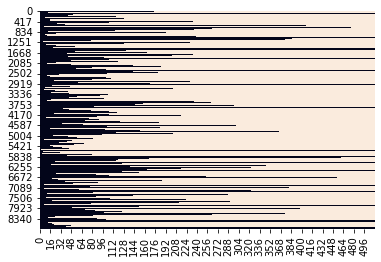

In [ ]:
sns.heatmap(X_train==0, vmin=0, vmax=1, cbar=False)
plt.show()

In [ ]:
i = 0

## list of text: ["I like this", ...]
len_txt = len(train_df["text"].iloc[i].split())
print("from: ", train_df["text"].iloc[i], "| len:", len_txt)

## sequence of token ids: [[1, 2, 3], ...]
len_tokens = len(X_train[i])
print("to: ", X_train[i], "| len:", len(X_train[i]))

## vocabulary: {"I":1, "like":2, "this":3, ...}
print("check: ", train_df["text"].iloc[i].split()[0], 
      " -- idx in vocabulary -->", 
      dic_vocabulary[train_df["text"].iloc[i].split()[0]])

print("vocabulary: ", dict(list(dic_vocabulary.items())[0:10]), "... (padding element, 0)")

In [ ]:
corpus_test = test_df["text"]

## create list of n-grams
lst_corpus_test = []
for string in corpus_test:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, 
                 len(lst_words), 1)]
    lst_corpus_test.append(lst_grams)
    
## detect common bigrams and trigrams using the fitted detectors
lst_corpus_test = list(bigrams_detector[lst_corpus_test])
# lst_corpus_test = list(trigrams_detector[lst_corpus_test])
## text to sequence with the fitted tokenizer
lst_text2seq = tokenizer.texts_to_sequences(lst_corpus_test)

## padding sequence
X_test = kprocessing.sequence.pad_sequences(lst_text2seq, maxlen=MAX_LEN,
             padding="post", truncating="post")

In [ ]:
## start the matrix (length of vocabulary x vector size) with all 0s
embeddings = np.zeros((len(dic_vocabulary)+1, 300))
for word,idx in dic_vocabulary.items():
    ## update the row with vector
    try:
        embeddings[idx] =  nlp[word]
    ## if word not in model then skip and the row stays all 0s
    except:
        pass

In [ ]:
print("dic[word]:", dic_vocabulary[word], "|idx")
print("embeddings[idx]:", embeddings[dic_vocabulary[word]].shape, 
      "|vector")

### Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Concatenate
class Attention(tf.keras.Model):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
 
    def call(self, features, hidden):
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = tf.nn.tanh(
            self.W1(features) + self.W2(hidden_with_time_axis))
        
        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
 
        return context_vector, attention_weights

In [ ]:
# code attention layer
def attention_layer(inputs, neurons):
    x = layers.Permute((2,1))(inputs)
    x = layers.Dense(neurons, activation="softmax")(x)
    x = layers.Permute((2,1), name="att")(x)
    x = layers.multiply([inputs, x])
    return x

## input
x_in = layers.Input(shape=(MAX_LEN,))
## embedding
x = layers.Embedding(input_dim=embeddings.shape[0],  
                     output_dim=embeddings.shape[1], 
                     weights=[embeddings],
                     input_length=MAX_LEN, trainable=False)(x_in)
## apply attention
x = attention_layer(x, neurons=MAX_LEN)
## 2 layers of bidirectional lstm
x = layers.Bidirectional(layers.LSTM(units=MAX_LEN, dropout=0.2, return_sequences=True))(x)
(lstm, forward_h, forward_c, backward_h, backward_c) = layers.Bidirectional(layers.LSTM(units=MAX_LEN, dropout=0.2, return_sequences=True, return_state=True))(x)
state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])

context_vector, attention_weights = Attention(MAX_LEN)(lstm, state_h)
## final dense layers
x = layers.Dense(64, activation='relu')(context_vector)
y_out = layers.Dense(len(LABEL_COLUMNS), activation='sigmoid')(x)
## compile
model = models.Model(x_in, y_out)
# bp_mll_loss
model.compile(loss='binary_crossentropy',
              optimizer='adam', metrics=['accuracy'])
# model.compile(loss='bp_mll_loss',
#               optimizer='adam', metrics=['accuracy'])

model.summary()

In [ ]:
y_train = train_df[LABEL_COLUMNS].values
y_test = test_df[LABEL_COLUMNS].values

## Training

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
W2V_MODEL_PATH = "YOUR_SAVE_MODEL"
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
mcp_save = ModelCheckpoint(W2V_MODEL_PATH, save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, epsilon=1e-4, mode='min')

callbacks=[earlyStopping, mcp_save, reduce_lr_loss]


In [ ]:
## encode y
# dic_y_mapping = {n:label for n,label in 
#                  enumerate(np.unique(y_train))}
# inverse_dic = {v:k for k,v in dic_y_mapping.items()}
# y_train = np.array([inverse_dic[y] for y in y_train])
## train
# training = model.fit(x=X_train, y=y_train, batch_size=256, 
#                      epochs=10, shuffle=True, verbose=0, 
#                      validation_split=0.3)
training = model.fit(x=X_train, y=y_train, batch_size=128, 
                     epochs=50, shuffle=True, callbacks=callbacks, verbose=1,
                     validation_data=(X_test, y_test))
model.save_weights(W2V_MODEL_PATH)

In [ ]:
## plot loss and accuracy
metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True)
ax[0].set(title="Training")
ax11 = ax[0].twinx()
ax[0].plot(training.history['loss'], color='black')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss', color='black')
for metric in metrics:
    ax11.plot(training.history[metric], label=metric)
ax11.set_ylabel("Score", color='steelblue')
ax11.legend()
ax[1].set(title="Validation")
ax22 = ax[1].twinx()
ax[1].plot(training.history['val_loss'], color='black')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss', color='black')
for metric in metrics:
     ax22.plot(training.history['val_'+metric], label=metric)
ax22.set_ylabel("Score", color="steelblue")
plt.show()

In [ ]:
# W2V_MODEL_PATH = "SAVED_MODEL"
# model.save_weights(W2V_MODEL_PATH)

In [ ]:
predicted_prob = model.predict(X_test)

33/33 [==============================] - 8s 163ms/step


In [ ]:
THRESHOLD = YOUR_THRESHOLD
upper, lower = 1, 0

y_pred = np.where(predicted_prob > THRESHOLD, upper, lower)

print(classification_report(
  y_test, 
  y_pred, 
  target_names=LABEL_COLUMNS, 
  zero_division=0
))

In [ ]:
hamming_score(y_pred, y_test)